# Network Reconstruction Methods for recovering the degree distribution 

This notebook is implementing some of Raul's methods for recovering the degree distribution of edge-sampled networks. 

## Notation:
* $G(V,E)$ original graph with $N$ nodes, $M$ links. 
* Sampled graph $G'(V',E')$ with $N'$ nodes, $M'$ links.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import Counter
a4_dims = (11.69,8.27)
import seaborn as sns
from scipy.special import comb

import time

## Util functions for edge sampling

First are some functions for getting binomial probabilities and for edge-sampling a network.

In [2]:
from math import sqrt, pi, exp

def normal_pdf(x, m, v):
    return 1.0/sqrt(2*pi*v) * exp(-(x-m)**2/(2*v))

## binomial function which will be useful for Bayes
def binom(k,k_sampled,p):
    if k < 100:
        return comb(k,k_sampled)* p**k_sampled * (1.0-p) ** (k-k_sampled)
    else: 
        return normal_pdf(k_sampled, k*p, k*p*(1.0-p))

n=200
k = 60
p=0.2
print(binom(n,k,p))
print(comb(n,k)* p**k * (1-p) ** (n-k))
del k

0.00013614276439704437
0.00021978685806698563


In [21]:
from scipy import special
from numpy import exp
from numpy.lib.scimath import log
lgam = special.gammaln

def binom(n:int, k:int, p):
    if p!=1.0:
        return exp(lgam(n+1) - lgam(n-k+1) - lgam(k+1) + k*log(p) + (n-k)*log(1.-p))
    else:
        if k==n:
            return 1.0
        else:
            return 0.0

In [4]:
def edge_sample(G,p,random_seed=None):
    # optionally seed for reproducibility
    random.seed(random_seed)
    H = nx.Graph()
    for (u,v) in G.edges:
        if random.random()<p:
            H.add_edge(u,v)
    return H

## MME Estimator

The first estimator we use is what was described in Ganguly et al's paper as the MME (method of moments estimator), defined as $\hat{k} = k'/p$. It is an unbiased maximum likelihood estimator for the parameter $k$ in a binomial random variable $k' \sim B(k,p)$.

### Notes 
* We round each obtained degree to an integer.
* Because of observed sampled degrees being an integer, all estimated degrees are multiples of $1/p$. E.g. if $p=0.05$ our estimated degrees will all be something like 20, 40 etc.

In [5]:
## Basic estimator for degree sequence which does not redistribute any spare or missing links
def deg_MME_basic(k_seq,sample_prob,as_int=False):
    if sample_prob==0.0:
        return np.zeros(shape=len(k_seq), dtype=float)
    estimated = k_seq/sample_prob
    if (as_int):
        return np.array([*map(int,estimated)])
    return estimated

print(deg_MME_basic(np.array([3,2,5,2]),0.5,True))

[ 6  4 10  4]


## Corrected MME estimator

Here we take into account the estimated number of links $M'/p$. Depending on the value of $p$ (specifically, whether or not $1/p$ is an integer), since each degree is rounded, we may not have the relation $\lfloor 2M'/p \rfloor = \sum_{i=1}^{N'} \lfloor k_i'/p \rfloor $ that is an identity for proper graph degree sequences. We may have too high or too low *total degree* (RHS).

In this procedure, we first calculate the basic MME estimator for the degree sequence and for the number of links, then adjust for differences by either randomly adding links or randomly removing links as required.

### Notes
* If $1/p$ is an integer, this procedure won't change anything as the estimated number of links (multiplied by 2) will be equal to the expected degree sum.

In [6]:
## Estimator which first obtains MME one then deals with rounding discrepency by redistributing links
def deg_MME(kp_seq, probability_keep, redistribute_links=True):

    # Number of nodes/links in sampled graph
    N_prime, M_prime = len(kp_seq), sum(kp_seq)/2

    ## Estimated number of links from sampled graph
    M_estimated = int(M_prime/probability_keep)

    ## Sampled and scaled-up degree distribution
    k_prime = np.array(kp_seq)
    k_est = deg_MME_basic(k_seq=k_prime,sample_prob=probability_keep,as_int=True)

    if (redistribute_links==False):
        return np.array(k_est)

    ## "Left over" stubs from the rounding process
    k_spare = 2*M_estimated - sum(k_est)

    ## Distribute these random stubs if there are any
    if k_spare>0:
        sampled_nodes = random.sample(range(N_prime),k_spare)
        for node in sampled_nodes:
            k_est[node]+=1

    ## If we have given nodes more connections than there are links, randomly remove some
    if k_spare<0:
        non_isolated_nodes = list(filter(lambda ind: k_est[ind]>0, range(N_prime)))
        sampled_nodes = random.sample(non_isolated_nodes,abs(k_spare))
        for node in sampled_nodes:
            k_est[node]-=1
    
    return np.array(k_est) 

## Univariate Risk Minimiser

from Estimation of Vertex Degrees in a Sampled Network, A. Ganguly and E. Kolaczyk. Does not improve upon the MME very much at all.

In [7]:
def deg_RME(kp_seq, probability_keep):
    k_prime = np.array(kp_seq)

    minimiser = lambda k: k**2/(probability_keep * (k + 1 - probability_keep)) + (1-probability_keep)/probability_keep
    return minimiser(k_prime)

# H = nx.erdos_renyi_graph(10,0.1)
# print(deg_RME(H,0.5))
# print(deg_MME(H,0.5,False))

## Monte Carlo estimator

This process starts off with the degree sequence estimated by the MME and tries to improve it by comparing samples from that estimated degree sequence of $G$ with our observed degree sequence in $G'$. 

At each step, a link in the estimated degree distribution is randomly rewired and we calculate the expected degree sequence if we were link-sampling it with probability $p$. If it is closer to the degree sequence of $G'$ than before, then we accept the proposed rewire, otherwise reject.

In [8]:
## Process for randomly redistributing links
def monte_carlo_degree(kp_seq,probability_keep):

    # Number of nodes/links in sampled graph
    N_prime, M_prime = len(kp_seq), sum(kp_seq)/2

    observed_degree = np.array(kp_seq)
    estimated_degree = deg_MME(kp_seq, probability_keep=probability_keep,redistribute_links=True)

    ## Expected degree of sampled network according to binomial
    sampled_sequence = estimated_degree * probability_keep *1.0
    #print(sampled_sequence)

    ## Sum of squared distances as base quality metric
    ssd_current = sum((sampled_sequence - observed_degree)**2)
    #print(observed_degree)
    
    # Commence Monte Carlo process
    # NB stuck in global minima if 1/p is an integer.
    cts_accept=0
    for i in range(15000):
        valid_indices = [ind for ind in range(N_prime) if estimated_degree[ind]>1]

        ## Randomly rewire an edge
        [n1, n2] = random.sample(valid_indices,2)
        # if i==1:
        #     print(n1,n2)

        # ## Ensure we don't leave any isolated nodes
        # while(estimated_degree[n1]<=1):
        #     [n1,n2] = random.sample(range(N_prime),2)
        # estimated_degree[n1]-=1
        # estimated_degree[n2]+=1

        sampled_sequence = estimated_degree * probability_keep
        ssd_new = sum((sampled_sequence - observed_degree)**2)

        ## Reject step if error is larger:
        if (ssd_new > ssd_current):
            estimated_degree[n1]+=1
            estimated_degree[n2]-=1
        else:
            ssd_current = ssd_new
            cts_accept+=1

    return estimated_degree, ssd_current, cts_accept



## Link cascade method
Previously used methods do not take into account isolated nodes, they only compare the difference in degree for nodes that are in $G'$ (i.e. those that end up with degree $>=1$). The following method assumes we know the number of nodes which end up being degree 0 in $G'$.

1. Start off with the MME estimate of the degree sequence (including the zeros for isolated nodes).
2. Rank the nodes in decreasing order of degree.
3. Find the highest rank node that has degree 0, and steal a link from the node directly above it in the rankings.
4. Repeat step 3 until there are no zero-degree nodes.

In [9]:
def degree_cascade(kp_seq, no_isolates, probability_keep):
    
    # Number of nodes/links in sampled graph
    N_prime, M_prime = len(kp_seq), sum(kp_seq)/2

    ## Run monte carlo 
    mme_degrees_wo_isolates = deg_MME(kp_seq=kp_seq,probability_keep=probability_keep,redistribute_links=True)
    mme_degrees = np.concatenate([mme_degrees_wo_isolates,np.zeros(no_isolates,dtype=int)])

    ## get the permutation of degrees into right order and the reverse of this.
    node_index = np.argsort(-1*mme_degrees)
    reverse_index = np.argsort(node_index)

    inds = list(filter(lambda i: mme_degrees[i]==0,node_index))

    ## make sorted list as a copy
    mme_degrees_copy = [mme_degrees[i] for i in node_index]
    while (len(inds)>0):
        # find highest node in the list that has degree 0.
        ind = inds.pop(0)
        mme_degrees_copy[ind-1] -= 1
        mme_degrees_copy[ind] += 1
        if (mme_degrees_copy[ind-1]==0):
            inds.insert(0,ind-1)

    cascaded_degrees = [mme_degrees_copy[i] for i in reverse_index]
    return cascaded_degrees

## Bayes method

This part uses the Bayes method of chapter 6 of my thesis to construct a posterior degree distribution. However, this time, instead of just using Poisson and true prior, we use these 3 estimates of the degree distribution as a prior, named "MME", "Cascaded" and "Monte Carlo".

In [10]:
## Bayes estimate, nb supply the prior as a degree sequence rather than counts of different degrees.
def bayes_approx(prior_as_sequence,sampled_graph,prob_retain):
    observed = np.array([d for (_,d) in nx.degree(sampled_graph)])
    N_approx = len(prior_as_sequence)

    ## transform from degree sequence to degree distribution
    deg_counts = Counter(prior_as_sequence)

    ## max value to use for the degree
    k_max = max(deg_counts.elements())

    ## construct prior from approx sequence
    prior = [deg_counts[k]/N_approx for k in range(k_max+1)]
    posterior = np.zeros(N_approx)

    for i in range(N_approx):
        k_observed = observed[i]
        k_range = np.array(range(k_observed,k_max+1))

        ## lambda function so can be applied to numpy array
        binom_ev = lambda k : binom(k,k_observed,prob_retain)

        denom = np.dot(binom_ev(k_range),prior[k_observed:k_max+1])
        numer = np.dot(binom_ev(k_range)*k_range,prior[k_observed:k_max+1])
        if (denom>0):
            posterior[i]=numer/denom
    return posterior
    

In [12]:
## Utility function for mean squared difference between two arrays
def mse(seq1, seq2):
    return sum((seq1-seq2)**2)/len(seq1)

## Main experiment. 

We start with an Erdos-Renyi graph of 1000 nodes and 5000 edges (average degree 10). We make edge samples going from $p=0.05$ to $p=1.0$ going up by 0.05. For each parameter we run 10 experiments and collect the mean and sd to get error bars.

The estimators we are interested in are:
* MME ($k'/p$ estimator)
* "Cascaded" links estimator
* Monte Carlo estimator
* Bayes with MME prior
* Bayes with cascaded links prior
* Bayes with Monte Carlo prior
* Bayes with true prior (we expect this to give an almost exact answer)

The error metric to compare the real and estimated degree sequence is the mean squared error in all cases.

In [23]:
# N,M=1000,5000
# G = nx.gnm_random_graph(N,M)

folder = "BA_FILES"
net_name = "BA"
p_range = np.linspace(0.1,0.9,9)

G = nx.read_edgelist(folder+"/REAL")

experiments = 10

mme = np.zeros((experiments,len(p_range)))
monte_carlo = np.zeros((experiments,len(p_range)))
cascade = np.zeros((experiments,len(p_range)))
bayes_mc = np.zeros((experiments,len(p_range)))
bayes_csc = np.zeros((experiments,len(p_range)))
bayes_true = np.zeros((experiments,len(p_range)))

def single_run(run_number):
    for ind, p in enumerate(p_range):
        H = nx.read_edgelist(folder+"/"+net_name+str(round(p,1))+"-"+str(run_number))
        kp_seq = [d for (_,d) in nx.degree(H)]

        ## True degree sequence of nodes in G that are in H
        true_degrees = np.array([nx.degree(G)[n] for n in H.nodes])
        full_degrees = np.array([nx.degree(G)[n] for n in H.nodes]+[nx.degree(G)[n] for n in G.nodes if n not in H.nodes])

        ## MME and associated error
        print("Calculating MME")
        #start = time.time()

        mme_seq = deg_MME(kp_seq,p,True)
        mme[run_number,ind] = mse(mme_seq,true_degrees)
        #print(time.time() - start)

        ## Cascaded degrees and error
        #print("Cascaded degrees")
        #start = time.time()

        csc_seq = degree_cascade(kp_seq,len(full_degrees) - len(true_degrees),p)
        cascade[run_number,ind] = mse(csc_seq,full_degrees)
        #print(time.time() - start)

        ## Monte carlo improvement
        print("Monte Carlo Degree")
        #start = time.time()

        # deg, ssd_error, accepted = monte_carlo_degree(kp_seq,p)
        # monte_carlo[run_number,ind] = mse(deg,true_degrees)
        #print(time.time() - start)
        
        ## Bayes using monte carlo
        #print("Bayes")
        #start = time.time()

        posterior_mc = bayes_approx(mme_seq,H,p)
        bayes_mc[run_number,ind] = mse(posterior_mc,true_degrees)
        #print(time.time() - start)

        ## Bayes using cascaded degrees
        #print("Bayes Cascaded")
        #start = time.time()

        csc_H = np.array(csc_seq[:H.number_of_nodes()])
        csc_bayes_degrees = bayes_approx(csc_H,H,p)
        bayes_csc[run_number,ind] = mse(csc_bayes_degrees,true_degrees)
        #print(time.time() - start)
        
        ## Bayes using true prior
        #print("Bayes True Prior")
        #start = time.time()     

        posterior_true = bayes_approx(true_degrees,H,p)
        bayes_true[run_number,ind] = mse(posterior_true,true_degrees)
        #print(time.time() - start)

for ex in range(experiments):
    print("Experiment "+str(ex))
    single_run(ex)
    
mme_means, mme_sds = np.sqrt(mme).mean(axis=0), np.sqrt(mme).std(axis=0)
csc_means, csc_sds = np.sqrt(cascade).mean(axis=0), cascade.std(axis=0)
monte_carlo_means, monte_carlo_sds = monte_carlo.mean(axis=0), monte_carlo.std(axis=0)
bayes_mc_means, bayes_mc_sds = bayes_mc.mean(axis=0), bayes_mc.std(axis=0)
bayes_mc_means, bayes_mc_sds = bayes_mc.mean(axis=0), bayes_mc.std(axis=0)
bayes_csc_means, bayes_csc_sds = bayes_csc.mean(axis=0), bayes_csc.std(axis=0)
bayes_true_means, bayes_true_sds = bayes_true.mean(axis=0), bayes_true.std(axis=0)
    

Experiment 0
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Experiment 1
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Experiment 2
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Calculating MME
Monte Carlo Degree
Experiment 3
Cal

In [24]:
results_df = pd.DataFrame(data=np.transpose([mme_means, mme_sds,csc_means, csc_sds, monte_carlo_means, monte_carlo_sds, bayes_mc_means, bayes_mc_sds,bayes_csc_means, bayes_csc_sds, bayes_true_means, bayes_true_sds]), columns = ["mme_mean", "mme_sd","csc_mean","csc_sd","monte_carlo_mean","monte_carlo_sd","bayes_mc_mean","bayes_mc_sd","bayes_csc_mean","bayes_csc_sd","bayes_true_mean","bayes_true_sd"],index=p_range)
display(results_df)
results_df.to_csv(folder+"/degree_error_dataframe.csv", index=True)

,mme_mean,mme_sd,csc_mean,csc_sd,monte_carlo_mean,monte_carlo_sd,bayes_mc_mean,bayes_mc_sd,bayes_csc_mean,bayes_csc_sd,bayes_true_mean,bayes_true_sd
0.1,13.501741,0.444643,13.619077,8.817715,0.0,0.0,125.255728,7.672283,125.311046,7.684467,112.471004,10.046323
0.2,8.783018,0.220808,8.984255,3.636357,0.0,0.0,55.805613,3.351174,55.806730,3.352305,51.248403,3.185141
0.3,6.715706,0.142015,6.787633,1.849891,0.0,0.0,34.046212,1.828789,34.040530,1.822472,31.079231,2.626682
0.4,5.377983,0.111357,5.396392,1.162356,0.0,0.0,22.543054,1.309657,22.546303,1.315892,20.538015,1.326789
0.5,4.489557,0.140395,4.499216,1.250423,0.0,0.0,16.467780,1.286087,16.465036,1.287183,15.177627,1.336716
0.6,3.731057,0.088864,3.726943,0.794069,0.0,0.0,11.441861,0.750350,11.435235,0.763815,10.381759,0.733841
0.7,3.034941,0.057755,3.037027,0.371669,0.0,0.0,7.687000,0.361192,7.685180,0.345318,7.165933,0.314907
0.8,2.277137,0.056980,2.274240,0.320996,0.0,0.0,4.288563,0.294480,4.292759,0.302505,3.930044,0.303060
0.9,1.605954,0.055774,1.603425,0.180502,0.0,0.0,2.051178,0.156582,2.045230,0.159693,1.811767,0.172772


In [16]:
## shortcut to the plot/fill_inbetween fns
def plot_shaded_bars(xrange, means, sds, ax, marker, label=None):
    ax.plot(xrange,means,label=label, marker=marker)
    ax.fill_between(xrange,means - sds, means+sds, alpha=0.3)
    

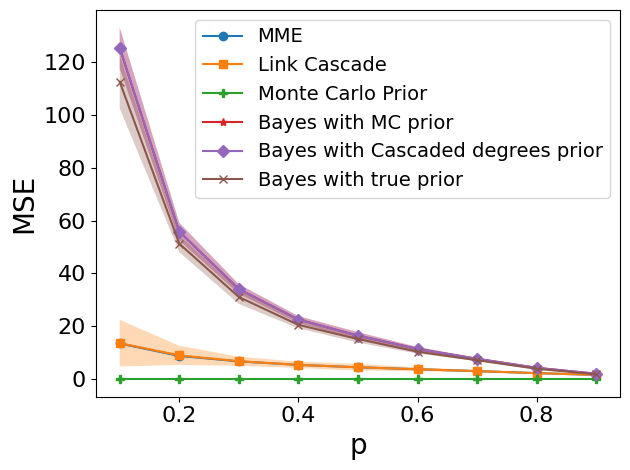

In [17]:
from matplotlib import rc

plt.rc('xtick',labelsize=16) 
plt.rc('ytick',labelsize=16)

## Comment below out if not using dark mode ;)
fig, ax = plt.subplots()
plot_shaded_bars(p_range,results_df["mme_mean"],results_df["mme_sd"],ax, marker="o",label="MME")
plot_shaded_bars(p_range,results_df["csc_mean"],results_df["csc_sd"],ax, marker="s",label="Link Cascade")
plot_shaded_bars(p_range,results_df["monte_carlo_mean"],results_df["monte_carlo_sd"],ax, marker="P",label="Monte Carlo Prior")
plot_shaded_bars(p_range,results_df["bayes_mc_mean"],results_df["bayes_mc_sd"],ax, marker="*",label="Bayes with MC prior")
plot_shaded_bars(p_range,bayes_csc_means,bayes_csc_sds,ax, marker="D",label="Bayes with Cascaded degrees prior")
plot_shaded_bars(p_range,bayes_true_means, bayes_true_sds,ax, marker="x", label="Bayes with true prior")

#ax.set_yscale('log')
ax.legend(loc="upper right", fontsize=14)
plt.xlabel("p", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.tight_layout()

plt.savefig(folder+"/"+net_name+"degree_mse.png")
plt.show()

# Triangle Count and Distribution Estimators

This section will use the estimators from degree but for the number of triangles per edge and in total.

## Basic functions

First we define some utility functions for counting number of common neighbours between node pairs and triangles per edge, as well as wedge counts

In [68]:
def common_neighbours(n1, n2, G):
    n1neigh = set(G.neighbors(n1))
    n2neigh = set(G.neighbors(n2))
    return len(n1neigh.intersection(n2neigh)), G.has_edge(n1,n2)

def triangles(n1, n2, G):
    if not G.has_edge(n1,n2):
        return 0
    else:
        return len(list(nx.common_neighbors(G,n1,n2)))

def edge_triangle_count(graph,edge_subset=None):
    if edge_subset is not None:
        edges = edge_subset
    else:
        edges = graph.edges()
    tc=[]
    for u,v in edges:
        tc.append(triangles(u,v,graph))
    return tc

def edge_triangle_dict(G):
    tc={}
    for u,v in G.edges():
        tc[(min(u,v),max(u,v))]=triangles(u,v,G)
    return tc


def local_wedge_count(G):
    nodes = sorted(G.nodes())
    ec = []
    for i in range(len(nodes)):
        for j in range(i):
            cn = common_neighbours(nodes[i],nodes[j],G)
            if cn[0]!=0:
                ec.append(cn[0])
    return ec

def wedge_count(G):
    return 0.5*sum([d*(d-1) for n,d in G.degree()])


## MME estimators for triangles and clustering

Some functions for MME estimators of clustering coefficient and triangle count.

In [69]:
def tri_MME(tri_array, p):
    return np.array([round(1.0/p**2*ct) for ct in tri_array])

def scaleup_wedge(H,p):
    return 1.0/p**2*wedge_count(H)

def scaleup_local_wedge(H,p):
    return 1.0/p**2*np.array(H)

def scaleup_clustering_coeff(H,p):
    wc = 1.0/p**2*wedge_count(H)
    t_array = tri_MME(edge_triangle_count(H),p)
    tc = sum(t_array)
    return t_array/wc

def tot_tri_estimate(H,p):
    tri_array = edge_triangle_count(H)/p**3
    return sum(tri_array)

## Probability Mass Functions for triangle count of sampled network

In [70]:
def triangle_likelihood(t,tc,p):
    return comb(t,tc)*np.power((1.0-p*p),t)

def triangle_likelihood_normalised(t,tc,p):
    return comb(t,tc)*np.power(p,2.0*tc)*np.power(1.0-p*p,t-tc)

In [71]:
## for making a cache of pre-calculated probabilities: like a defaultdict but it has 

from collections import defaultdict

class key_dependent_dict(defaultdict):
    def __init__(self,f_of_x):
        super().__init__(None) # base class doesn't get a factory
        self.f_of_x = f_of_x # save f(x)
    def __missing__(self, key): # called when a default needed
        ret = self.f_of_x(key) # calculate default value
        self[key] = ret # and install it in the dict
        return ret

In [72]:
from scipy.stats import poisson

def tri_bayes_approx_pois(tl_sampled, prob_retain, T_lambda):
    m = len(tl_sampled)
    # t_max = len(prior)-1

    posterior = np.zeros(m, dtype=float)

    # ## no need to keep re-evaluating probabilities over and over
    # prob_cache = key_dependent_dict(lambda x : binom(x[0],x[1],prob_retain**2))

    vectorised_binom_num = lambda tc: np.vectorize(lambda t: t*binom(t,tc,prob_retain**2),excluded=["tc"])
    vectorised_binom_den = lambda tc: np.vectorize(lambda t: binom(t,tc,prob_retain**2),excluded=["tc"])

    ## no need to keep re-evaluating probabilities over and over
    prob_cache_num = key_dependent_dict(lambda tc : poisson(T_lambda).expect(vectorised_binom_num(tc), lb=tc, maxcount=100))
    prob_cache_den = key_dependent_dict(lambda tc : poisson(T_lambda).expect(vectorised_binom_den(tc), lb=tc, maxcount=100))

    for edge in range(m):
        t_observed = tl_sampled[edge]
        # t_range = np.array(range(t_observed, t_max + 1))
        
        # binom_ev = np.vectorize(lambda t: prob_cache[(t,int(t_observed))],otypes=[float])

        # denom = poisson(T_lambda).expect(lambda t: t*binom(t,t_observed,prob_retain**2), lb=t_observed, maxcount=100)
        # numer = poisson(T_lambda).expect(lambda t: binom(t,t_observed,prob_retain**2), lb=t_observed, maxcount=100)
        
        denom = prob_cache_den[t_observed]
        numer = prob_cache_num[t_observed]
        if (denom > 0):
            posterior[edge] = numer/denom
        else:
            posterior[edge] = 0.0

    return np.array(posterior)

def poisson_prior(mean, tol):
    total = 0.0
    ind = 0
    prior_arr = []
    
    while (total < 1.0-tol):
        prior_arr.append(poisson.pmf(ind,mean))
        total+=prior_arr[-1]
        ind+=1
    return np.array(prior_arr)

In [73]:
def tri_bayes_approx_true(tl_sampled, prob_retain, dist):
    m = len(tl_sampled)
    # t_max = len(prior)-1

    posterior = np.zeros(m, dtype=float)

    # ## no need to keep re-evaluating probabilities over and over
    # prob_cache = key_dependent_dict(lambda x : binom(x[0],x[1],prob_retain**2))

    vectorised_binom_num = lambda tc: np.vectorize(lambda t: t*binom(t,tc,prob_retain**2),excluded=["tc"])
    vectorised_binom_den = lambda tc: np.vectorize(lambda t: binom(t,tc,prob_retain**2),excluded=["tc"])

    ## no need to keep re-evaluating probabilities over and over
    prob_cache_num = key_dependent_dict(lambda tc : dist.expect(vectorised_binom_num(tc), lb=tc, maxcount=100))
    prob_cache_den = key_dependent_dict(lambda tc : dist.expect(vectorised_binom_den(tc), lb=tc, maxcount=100))

    for edge in range(m):
        t_observed = tl_sampled[edge]
        # t_range = np.array(range(t_observed, t_max + 1))
        
        # binom_ev = np.vectorize(lambda t: prob_cache[(t,int(t_observed))],otypes=[float])

        # denom = poisson(T_lambda).expect(lambda t: t*binom(t,t_observed,prob_retain**2), lb=t_observed, maxcount=100)
        # numer = poisson(T_lambda).expect(lambda t: binom(t,t_observed,prob_retain**2), lb=t_observed, maxcount=100)
        
        denom = prob_cache_den[t_observed]
        numer = prob_cache_num[t_observed]
        if (denom > 0):
            posterior[edge] = numer/denom
        else:
            posterior[edge] = 0.0

    return np.array(posterior)

def poisson_prior(mean, tol):
    total = 0.0
    ind = 0
    prior_arr = []
    
    while (total < 1.0-tol):
        prior_arr.append(poisson.pmf(ind,mean))
        total+=prior_arr[-1]
        ind+=1
    return np.array(prior_arr)

In [94]:
# N,M=1000,10000
# G = nx.gnm_random_graph(N,M)

# G = nx.powerlaw_cluster_graph(10000,5,0.3)

from scipy.stats import rv_discrete

folder="InterNaomi"
name="INTER"
G = nx.read_edgelist(folder+'/REAL')
M = G.number_of_edges()

Tl_real_full = edge_triangle_count(G)
maxT = max(Tl_real_full)
T_real = sum(Tl_real_full)/3.0

t_counts = Counter(Tl_real_full)
pk = [t_counts[t]/M for t in range(0,maxT + 1)]
true_prior = rv_discrete("true",values= (np.array(range(maxT+1)), pk))

p_range = np.linspace(0.1,0.9,9)
experiments = 10

mme_tri_dist_err = np.zeros((experiments,len(p_range)))
mme_tri_tot_err = np.zeros((experiments,len(p_range)))

bayes_pois_dist_err = np.zeros((experiments,len(p_range)))
bayes_pois_tot_err = np.zeros((experiments,len(p_range)))

bayes_true_dist_err = np.zeros((experiments,len(p_range)))
bayes_true_tot_err = np.zeros((experiments,len(p_range)))

def single_run_tri(run_number):
    for ind, p in enumerate(p_range):
        H = nx.read_edgelist(folder+'/'+name+str(round(p,1))+'-'+str(run_number))

        N_prime, M_prime = H.number_of_nodes(), H.number_of_edges()
        missing_edges = round(M_prime*(1.0/p - 1.0))

        ## Sampled triangle counts and total
        tl_sampled = np.array(edge_triangle_count(H, H.edges())+[0 for _ in range(missing_edges)])
        T_sampled = sum(tl_sampled)/3.0

        ## Real edge triangle count over the subset of H's edges
        tl_real = edge_triangle_count(G,H.edges())

        ## MME scaleup
        mme_tri = tri_MME(tl_sampled,p)
        T_mme = T_sampled/p**3

        mme_tri_dist_err[run_number, ind] = mse(mme_tri[:M_prime],tl_real[:M_prime])
        mme_tri_tot_err[run_number,ind] = (T_mme - T_real)**2

        ## Bayes approx Poisson
        T_lambda = T_mme*3.0/(M_prime + missing_edges)

        bayes_true_tri = tri_bayes_approx_true(tl_sampled[:M_prime], p, true_prior)
        bayes_true_dist_err[run_number,ind] = mse(bayes_true_tri[:M_prime],tl_real[:M_prime])

        # bayes_pois_tri = tri_bayes_approx(tl_sampled[:M_prime],p,poisson_prior(T_lambda,0.000001))
        bayes_pois_tri = tri_bayes_approx_pois(tl_sampled[:M_prime],p,T_lambda)
        bayes_pois_dist_err[run_number,ind] = mse(bayes_pois_tri[:M_prime],tl_real[:M_prime])

        T_bayes_pois = sum(bayes_pois_tri)/(3.0 * p)
        T_bayes_true = sum(bayes_true_tri)/(3.0 * p)
        bayes_pois_tot_err[run_number,ind] = (T_bayes_pois - T_real)**2
        bayes_true_tot_err[run_number,ind] = (T_bayes_true - T_real)**2

        
for ex in range(experiments):
    print("Experiment "+str(ex))
    single_run_tri(ex)

Experiment 0


/var/folders/k1/wfjdy3kn5w736s1x5gztt_4w0000gn/T/ipykernel_74890/521940070.py:6: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  return exp(lgam(n+1) - lgam(n-k+1) - lgam(k+1) + k*log(p) + (n-k)*log(1.-p))
/var/folders/k1/wfjdy3kn5w736s1x5gztt_4w0000gn/T/ipykernel_74890/521940070.py:6: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return exp(lgam(n+1) - lgam(n-k+1) - lgam(k+1) + k*log(p) + (n-k)*log(1.-p))


Experiment 1
Experiment 2
Experiment 3
Experiment 4
Experiment 5
Experiment 6
Experiment 7
Experiment 8
Experiment 9


In [95]:
mme_tri_dist_mean = mme_tri_dist_err.mean(axis=0)
mme_tri_tot_mean = mme_tri_tot_err.mean(axis=0)
mme_tri_dist_sd = mme_tri_dist_err.std(axis=0)
mme_tri_tot_sd = mme_tri_tot_err.std(axis=0)

bayes_tri_dist_mean = bayes_pois_dist_err.mean(axis=0)
bayes_tri_tot_mean = bayes_pois_tot_err.mean(axis=0)
bayes_tri_dist_sd = bayes_pois_dist_err.std(axis=0)
bayes_tri_tot_sd = bayes_pois_tot_err.std(axis=0)

bayes_tri_true_dist_mean = bayes_true_dist_err.mean(axis=0)
bayes_tri_true_tot_mean = bayes_true_tot_err.mean(axis=0)
bayes_tri_true_dist_sd = bayes_true_dist_err.std(axis=0)
bayes_tri_true_tot_sd = bayes_true_tot_err.std(axis=0)


In [96]:
results_df = pd.DataFrame(data=np.transpose([mme_tri_dist_mean, mme_tri_dist_sd,mme_tri_tot_mean, mme_tri_tot_sd, 
bayes_tri_dist_mean, bayes_tri_dist_sd, bayes_tri_tot_mean, bayes_tri_tot_sd, 
bayes_tri_true_dist_mean, bayes_tri_true_dist_sd, bayes_tri_true_tot_mean, bayes_tri_true_tot_sd]), 
columns = ["mme_dist_mean", "mme_dist_sd","mme_tot_mean","mme_tot_sd",
"bayes_dist_mean","bayes_dist_sd","bayes_tot_mean","bayes_tot_sd",
"bayes_dist_true_mean","bayes_dist_true_sd","bayes_tot_true_mean","bayes_tot_true_sd"],index=p_range)
display(results_df)
results_df.to_csv(folder+"/tri_error_dataframe.csv", index=True)

,mme_dist_mean,mme_dist_sd,mme_tot_mean,mme_tot_sd,bayes_dist_mean,bayes_dist_sd,bayes_tot_mean,bayes_tot_sd,bayes_dist_true_mean,bayes_dist_true_sd,bayes_tot_true_mean,bayes_tot_true_sd
0.1,259.349034,97.256543,7.385964e+07,7.455884e+07,113.950736,67.531238,7.385964e+07,7.455884e+07,65.280660,27.669381,5.066912e+06,5.764673e+06
0.2,64.234622,11.642631,8.014673e+06,8.311052e+06,80.365792,18.526369,8.014673e+06,8.311052e+06,29.208510,3.785647,2.003964e+06,2.280349e+06
0.3,24.974740,2.645944,6.922173e+06,8.011185e+06,72.898521,13.344674,6.922086e+06,8.011418e+06,17.118496,1.090111,3.107724e+06,3.413868e+06
0.4,13.146250,1.202235,3.742632e+06,2.963454e+06,67.396189,16.136590,3.742309e+06,2.962829e+06,9.644939,0.687597,1.892236e+06,1.540438e+06
0.5,7.670958,0.622007,2.350906e+06,4.030946e+06,54.489911,8.920284,2.350906e+06,4.030946e+06,6.173309,0.552424,1.462389e+06,2.561301e+06
0.6,4.713131,0.303504,6.931424e+05,9.184359e+05,42.282530,11.529941,7.300687e+05,9.831074e+05,3.989103,0.428708,5.179195e+05,6.774342e+05
0.7,2.532841,0.183063,1.298696e+06,1.574332e+06,41.252273,7.537273,1.406880e+06,1.581771e+06,2.297230,0.109458,1.065493e+06,1.264710e+06
0.8,1.498348,0.080018,3.960736e+05,3.466772e+05,32.666597,6.929126,3.380063e+05,4.411006e+05,1.249041,0.090427,3.368307e+05,3.004686e+05
0.9,0.618667,0.039943,2.657698e+05,3.197518e+05,33.098961,4.548417,3.957111e+05,3.985367e+05,0.547974,0.049876,2.445543e+05,2.995696e+05


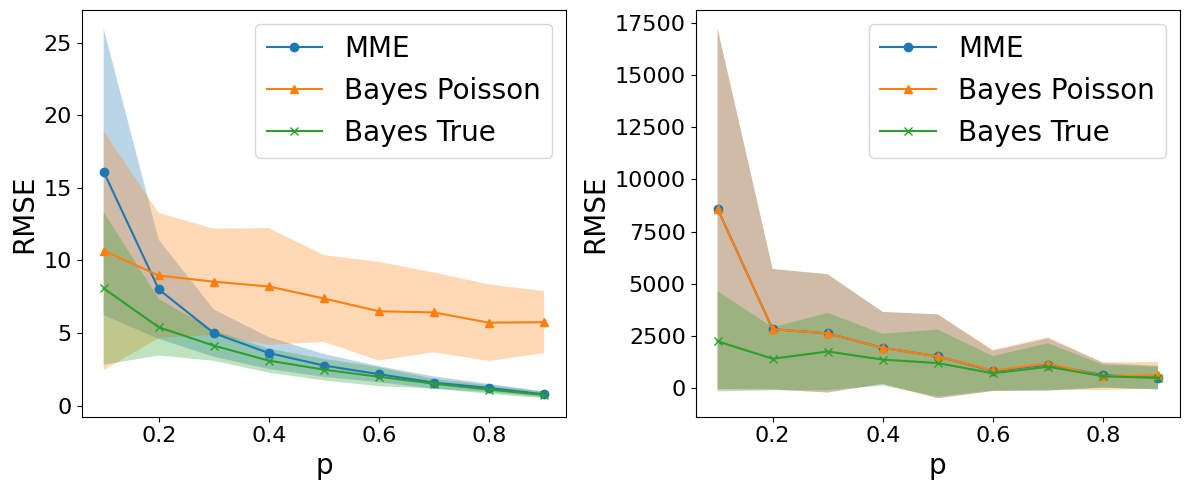

In [97]:
## Comment below out if not using dark mode ;)
p_range = np.linspace(0.1,0.9,9)
plt.style.use("default")
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
fig, ax = plt.subplots(1,2,figsize = (12,5))

ax1, ax2 = ax[0], ax[1]

plot_shaded_bars(p_range,np.sqrt(mme_tri_dist_mean),np.sqrt(mme_tri_dist_sd),ax1,label="MME", marker="o")
plot_shaded_bars(p_range,np.sqrt(bayes_tri_dist_mean),np.sqrt(bayes_tri_dist_sd),ax1,label="Bayes Poisson", marker="^")
plot_shaded_bars(p_range,np.sqrt(bayes_tri_true_dist_mean),np.sqrt(bayes_tri_true_dist_sd),ax1,label="Bayes True", marker="x")
plot_shaded_bars(p_range,np.sqrt(mme_tri_tot_mean),np.sqrt(mme_tri_tot_sd),ax2,label="MME", marker="o")
plot_shaded_bars(p_range,np.sqrt(bayes_tri_tot_mean),np.sqrt(bayes_tri_tot_sd),ax2,label="Bayes Poisson", marker="^")
plot_shaded_bars(p_range,np.sqrt(bayes_tri_true_tot_mean),np.sqrt(bayes_tri_true_tot_sd),ax2,label="Bayes True", marker="x")

# plot_shaded_bars(p_range,np.sqrt(mme_tri_dist_mean),mme_tri_dist_sd,ax1,label="MME")
# plot_shaded_bars(p_range,bayes_tri_dist_mean,bayes_tri_dist_sd,ax1,label="Bayes Poisson")
# plot_shaded_bars(p_range,mme_tri_tot_mean,mme_tri_tot_sd,ax2,label="MME")
# plot_shaded_bars(p_range,bayes_tri_tot_mean,bayes_tri_tot_sd,ax2,label="Bayes Poisson")

#ax.set_yscale('log')
ax1.legend(loc="upper right",fontsize=20)
ax2.legend(loc="upper right",fontsize=20)

ax1.set_xlabel("p",fontsize=20)
ax2.set_xlabel("p",fontsize=20)
ax1.set_ylabel("RMSE",fontsize=20)
ax2.set_ylabel("RMSE",fontsize=20)

plt.tight_layout()
plt.savefig(folder+"/tri_plot.png")

plt.show()

# Degree-degree correlations

In [18]:
# Returns the sequence of connections of higher rank
def k_plus(graph):
    no_nodes = graph.number_of_nodes()
    k_plus_arr = np.zeros(no_nodes,dtype=int)
    for n in range(no_nodes):
        k_plus_arr[n] = len(list(filter(lambda node: nx.degree(graph)[node] > nx.degree(graph)[n],nx.neighbors(graph,n))))
    return k_plus_arr

def k_minus(graph):
    degrees = np.array([d for (_,d) in nx.degree(graph)])
    return degrees - k_plus(graph)
